![](https://www.edureka.co/blog/wp-content/uploads/2018/06/spark-with-python2.png)


# Predicting House Prices with Apache Spark

In this kernel, we'll make use of the Housing data set. This is actually a small data and that using Spark in this context might be overkill; This notebook is for training purposes only and is meant to give an idea of how we can use PySpark to build a machine learning model.

The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.

These spatial data contain 20,640 observations on housing prices with 9 economic variables:

- Longitude:refers to the angular distance of a geographic place north or south of the earth’s equator for each block group
- Latitude :refers to the angular distance of a geographic place east or west of the earth’s equator for each block group
- Housing Median Age:is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values
- Total Rooms:is the total number of rooms in the houses per block group
- Total Bedrooms:is the total number of bedrooms in the houses per block group
- Population:is the number of inhabitants of a block group
- Households:refers to units of houses and their occupants per block group
- Median Income:is used to register the median income of people that belong to a block group
- Median House Value:is the dependent variable and refers to the median house value per block group

The Median house value is the dependent variable and will be assigned the role of the target variable in our ML model.

1. [Creating the Spark session](#1)
1. [Import packages and load data](#2)
1. [Data exploration](#3)
1. [Data Preprocessing](#4)
1. [Features engineering](#5)
1. [Features extraction](#6)
1. [Standardization](#7)
1. [Building A Machine Learning Model With Spark ML](#8)
1. [ Create an ElasticNet model](#9)
1. [Evaluating our first model](#10)
1. [Let's try some others models in Spark](#11)
1. [Third submission to Kaggle](#12)

<a id="1"></a> <br>
## Creating the Spark session

In [1]:
import findspark
findspark.init('C:/Users/Evan/SPARK/spark-3.0.0-preview2-bin-hadoop2.7')

In [2]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df = spark.sql('''select 'spark' as hello ''')
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



In [3]:
spark = SparkSession.builder\
.master("local[2]")\
.appName("Linear-Regression-California-Housing")\
.getOrCreate()

In [4]:
spark

In [5]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

<a id="2"></a> <br>
## Import packages and load data

In [70]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import (LinearRegression, GeneralizedLinearRegression,
DecisionTreeRegressor, RandomForestRegressor, GBTRegressor, AFTSurvivalRegression, IsotonicRegression)
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import DenseVector

In [8]:
# Visualization

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

Specifying the schema when loading data into a DataFrame will give better performance than schema inference.

In [10]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

In [11]:
# Load housing data
housing_df = spark.read.csv(path='cal_housing.data', schema=schema).cache()

<a id="3"></a> <br>
## Data exploration

In [183]:
housing_df.sample(False, 0.0005, 1234).toPandas()

,long,lat,medage,totrooms,totbdrms,pop,houshlds,medinc,medhv
0,-119.790001,36.720001,41.0,1562.0,322.0,927.0,277.0,1.3047,44100.0
1,-118.449997,34.049999,28.0,801.0,399.0,936.0,406.0,2.1875,181300.0
2,-118.110001,33.910000,36.0,1088.0,231.0,617.0,211.0,3.8824,193100.0
3,-116.760002,33.459999,6.0,1251.0,268.0,544.0,216.0,3.0694,173400.0
4,-117.059998,32.680000,38.0,1481.0,317.0,1080.0,291.0,2.8500,125800.0
5,-117.129997,32.709999,35.0,614.0,180.0,691.0,164.0,1.6953,81300.0
6,-116.940002,32.810001,8.0,2517.0,632.0,1686.0,613.0,2.1360,143500.0
7,-122.349998,40.560001,16.0,2801.0,614.0,1695.0,563.0,1.9000,81600.0
8,-120.279999,38.029999,13.0,2095.0,391.0,860.0,331.0,3.6838,145700.0


In [20]:
# show the dataframe columns
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [21]:
# show the schema of the dataframe
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



Let's group by housingmedianage and see the distribution :

In [25]:
result1 = housing_df.groupBy('medage').count().sort("medage", ascending = False)
result1.show(15)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
|  42.0|  368|
|  41.0|  296|
|  40.0|  304|
|  39.0|  369|
|  38.0|  394|
+------+-----+
only showing top 15 rows



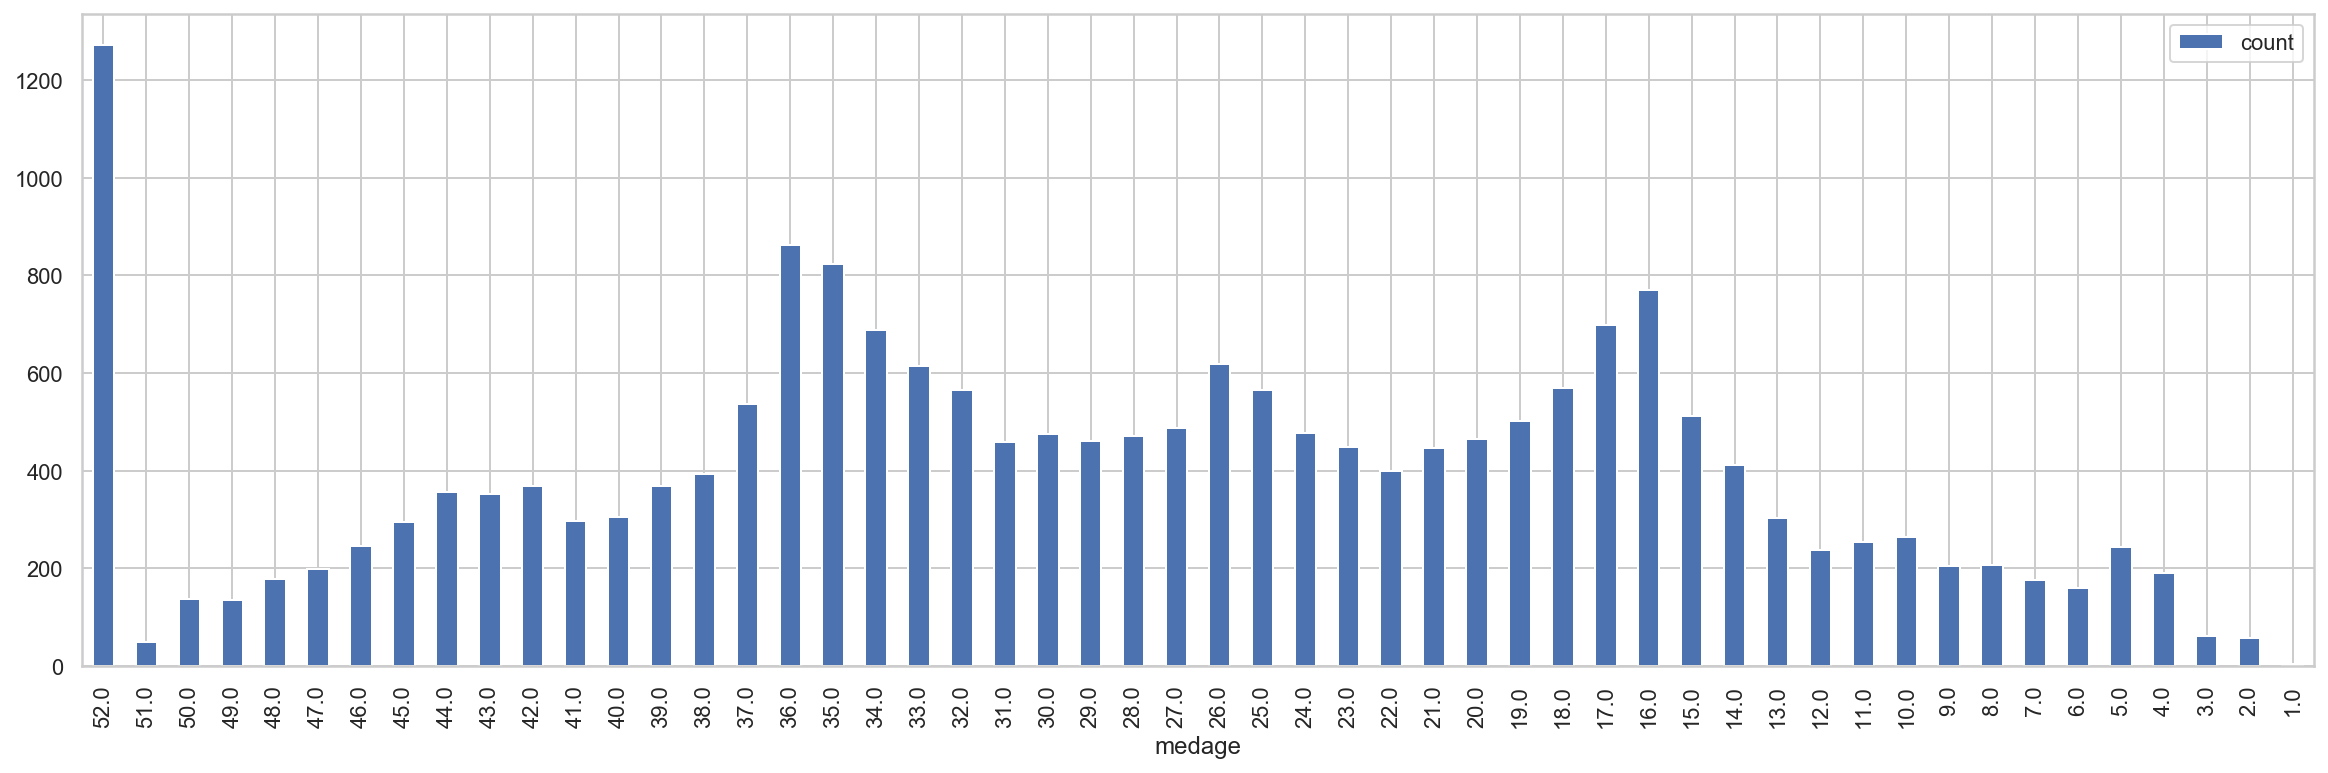

In [30]:
result1.toPandas().plot.bar("medage", figsize= (20,6));

Most of the residents are either in their youth or they settle here during their senior years (52). Some data are showing median age < 10 which seems to be out of place.

Let's quicly visualize some statistics, Spark DataFrames include some built-in functions for statistical processing. The describe() function performs summary statistics calculations on all numeric columns and returns them as a DataFrame.

In [34]:
housing_df.describe().toPandas()

,summary,long,lat,medage,totrooms,totbdrms,pop,houshlds,medinc,medhv
0,count,20640,20640,20640,20640,20640,20640,20640,20640,20640
1,mean,-119.56970444871473,35.63186143109965,28.639486434108527,2635.7630813953488,537.8980135658915,1425.4767441860465,499.5396802325581,3.8706710030346416,206855.81690891474
2,stddev,2.003531742932898,2.135952380602968,12.58555761211163,2181.6152515827944,421.247905943133,1132.46212176534,382.3297528316098,1.8998217183639696,115395.61587441359
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0


When we Look at the minimum and maximum values of all the (numerical) attributes. We can see that multiple attributes (like totrooms/totbdrms/pop/houshlds and so on) have a wide range of values. That certainly means that we will need to normalize your dataset.

<a id="4"></a> <br>
##  Data Preprocessing
With all this information that we gathered from our small exploratory data analysis, we know enough to preprocess our data to feed it to the model.

- we shouldn't care about missing values; all zero values have been excluded from the data set.
- We should probably standardize our data, as we have seen that the range of minimum and maximum values is quite big.
- There are possibly some additional attributes that we could add, such as a feature that registers the number of bedrooms per room or the rooms per household.
- Our dependent variable is also quite big; To make our life easier, we'll have to adjust the values slightly.

In [69]:
#adjust the values of medianhousevalue the target variable

housing_df = housing_df.withColumn('medhv', col('medhv')/100000)

In [13]:
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 5 rows



We can clearly see that the values have been adjusted correctly when we look at the result of the show() method:

<a id="5"></a> <br>
## Feature Engineering
Now that we have adjusted the values in medianHouseValue, we will now add the following columns to the data set:

Rooms per household which refers to the number of rooms in households per block group;

Population per household, which basically gives us an indication of how many people live in households per block group; And

Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group;

In [37]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [14]:
housing_df = (housing_df.withColumn("roomsperhousehold", F.round(col("totrooms")/col('houshlds'),2))
                        .withColumn("popperhousehold", F.round(col('pop')/col('houshlds'),2))
                        .withColumn("bedroomsperroom", F.round(col('totbdrms')/col('totrooms'),2)))

In [44]:
housing_df.sample(False, 0.0005, 1234).toPandas()

,long,lat,medage,totrooms,totbdrms,pop,houshlds,medinc,medhv,roomsperhousehold,popperhousehold,bedroomsperroom
0,-119.790001,36.720001,41.0,1562.0,322.0,927.0,277.0,1.3047,0.441,5.64,3.35,0.21
1,-118.449997,34.049999,28.0,801.0,399.0,936.0,406.0,2.1875,1.813,1.97,2.31,0.50
2,-118.110001,33.910000,36.0,1088.0,231.0,617.0,211.0,3.8824,1.931,5.16,2.92,0.21
3,-116.760002,33.459999,6.0,1251.0,268.0,544.0,216.0,3.0694,1.734,5.79,2.52,0.21
4,-117.059998,32.680000,38.0,1481.0,317.0,1080.0,291.0,2.8500,1.258,5.09,3.71,0.21
5,-117.129997,32.709999,35.0,614.0,180.0,691.0,164.0,1.6953,0.813,3.74,4.21,0.29
6,-116.940002,32.810001,8.0,2517.0,632.0,1686.0,613.0,2.1360,1.435,4.11,2.75,0.25
7,-122.349998,40.560001,16.0,2801.0,614.0,1695.0,563.0,1.9000,0.816,4.98,3.01,0.22
8,-120.279999,38.029999,13.0,2095.0,391.0,860.0,331.0,3.6838,1.457,6.33,2.60,0.19


We can see that, for the first row, there are about 5.64 rooms per household, the households in the block group consist of about 3.35 people and the amount of bedrooms is quite low with 0.21.

Since we don't want to necessarily standardize our target values, we'll want to make sure to isolate those in our data set. Note also that this is the time to leave out variables that we might not want to consider in our analysis. In this case, let's leave out variables such as longitude, latitude, housingMedianAge and totalRooms.

In this case, we will use the select() method and passing the column names in the order that is more appropriate. In this case, the target variable medianHouseValue is put first, so that it won't be affected by the standardization.

In [18]:
housing_df = housing_df.select("medhv", 
                  "totbdrms", 
                  "pop", 
                  "houshlds", 
                  "medinc", 
                  "roomsperhousehold", 
                  "popperhousehold", 
                  "bedroomsperroom")

In [19]:
housing_df.sample(False, 0.0005, 1234).toPandas()

,medhv,totbdrms,pop,houshlds,medinc,roomsperhousehold,popperhousehold,bedroomsperroom
0,0.441,322.0,927.0,277.0,1.3047,5.64,3.35,0.21
1,1.813,399.0,936.0,406.0,2.1875,1.97,2.31,0.50
2,1.931,231.0,617.0,211.0,3.8824,5.16,2.92,0.21
3,1.734,268.0,544.0,216.0,3.0694,5.79,2.52,0.21
4,1.258,317.0,1080.0,291.0,2.8500,5.09,3.71,0.21
5,0.813,180.0,691.0,164.0,1.6953,3.74,4.21,0.29
6,1.435,632.0,1686.0,613.0,2.1360,4.11,2.75,0.25
7,0.816,614.0,1695.0,563.0,1.9000,4.98,3.01,0.22
8,1.457,391.0,860.0,331.0,3.6838,6.33,2.60,0.19


In [20]:
housing_df.show(5)

+-----+--------+------+--------+------+-----------------+---------------+---------------+
|medhv|totbdrms|   pop|houshlds|medinc|roomsperhousehold|popperhousehold|bedroomsperroom|
+-----+--------+------+--------+------+-----------------+---------------+---------------+
|4.526|   129.0| 322.0|   126.0|8.3252|             6.98|           2.56|           0.15|
|3.585|  1106.0|2401.0|  1138.0|8.3014|             6.24|           2.11|           0.16|
|3.521|   190.0| 496.0|   177.0|7.2574|             8.29|            2.8|           0.13|
|3.413|   235.0| 558.0|   219.0|5.6431|             5.82|           2.55|           0.18|
|3.422|   280.0| 565.0|   259.0|3.8462|             6.28|           2.18|           0.17|
+-----+--------+------+--------+------+-----------------+---------------+---------------+
only showing top 5 rows



<a id="6"></a> <br>
## Feature Extraction

I will use DenseVector to put features into a feature vector column :

In [21]:
def transfodata(df):
    return df.rdd.map(lambda x : (x[0], DenseVector(x[1:]))).toDF(['label', 'features'])

In [22]:
df = transfodata(housing_df)

In [23]:
df.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|4.526|[129.0,322.0,126....|
|3.585|[1106.0,2401.0,11...|
|3.521|[190.0,496.0,177....|
|3.413|[235.0,558.0,219....|
|3.422|[280.0,565.0,259....|
+-----+--------------------+
only showing top 5 rows



Perfect, all the features have transformed into a Dense Vector

<a id="7"></a> <br>
## Standardization

Next, we can finally scale the data using StandardScaler. The input columns are the features, and the output column with the rescaled that will be included in the scaled_df will be named "features_scaled":

In [24]:
scaler = StandardScaler(inputCol = "features", outputCol = "featurescaled")

In [25]:
scaled_df = scaler.fit(df).transform(df)

In [26]:
scaled_df.sample(False, 0.0005, 1234).toPandas()

,label,features,featurescaled
0,0.441,"[322.0, 927.0, 277.0, 1.3047000169754028, 5.64, 3.35, 0.21]","[0.7643954912465936, 0.8185704247263872, 0.724505477139781, 0.6867486587630678, 2.279531557560062, 0.32254928191146326, 3.616023618236778]"
1,1.813,"[399.0, 936.0, 406.0, 2.1875, 1.97, 2.31, 0.5]","[0.9471857174142573, 0.8265177104033424, 1.0619105549413397, 1.1514238303811815, 0.7962193560981068, 0.2224145794673075, 8.6095800434209]"
2,1.931,"[231.0, 617.0, 211.0, 3.8824000358581543, 5.16, 2.92, 0.21]","[0.548370678502991, 0.5448305847423742, 0.551879623380844, 2.043560192164495, 2.08552887181027, 0.2811474337855142, 3.616023618236778]"
3,1.734,"[268.0, 544.0, 216.0, 3.0694000720977783, 5.79, 2.52, 0.21]","[0.6362049430251151, 0.4803692675848486, 0.5649573395747028, 1.6156253202226736, 2.3401573968568723, 0.24263408669160816, 3.616023618236778]"
4,1.258,"[317.0, 1080.0, 291.0, 2.8499999046325684, 5.09, 3.71, 0.21]","[0.7525259960409011, 0.9536742812346259, 0.7611230824825858, 1.5001407116699583, 2.057236813471758, 0.3572112942959787, 3.616023618236778]"
5,0.813,"[180.0, 691.0, 164.0, 1.6952999830245972, 3.74, 4.21, 0.29]","[0.4273018274049281, 0.6101749336417838, 0.42894909115857066, 0.8923468800454096, 1.5116042598004669, 0.40535297816336124, 4.993556425184122]"
6,1.435,"[632.0, 1686.0, 613.0, 2.135999917984009, 4.11, 2.75, 0.25]","[1.5003041939995252, 1.488791516816277, 1.6033280053670964, 1.124315980461274, 1.6611479967325986, 0.26477926127060414, 4.30479002171045]"
7,0.816,"[614.0, 1695.0, 563.0, 1.899999976158142, 4.98, 3.01, 0.22]","[1.4575740112590325, 1.4967388024932322, 1.472550843428508, 1.0000938286958452, 2.0127778646540975, 0.28981293688164306, 3.788215219105196]"
8,1.457,"[391.0, 860.0, 331.0, 3.683799982070923, 6.33, 2.6, 0.19]","[0.9281945250851493, 0.759407298020165, 0.8657448120334567, 1.9390240391836477, 2.558410418325389, 0.2503367561103894, 3.271640416499942]"


We can see that all the features have been scaled !

<a id="8"></a> <br>
## Building A Machine Learning Model With Spark ML
With all the preprocessing done, it's finally time to start building our Linear Regression model! Just like always, we first need to split the data into training and test sets. We will use the randomSplit() method:

In [27]:
train, test = scaled_df.randomSplit([0.8,0.2], seed = 1234)

We pass in a list with two numbers that represent the size that we want your training and test sets to have and a seed, which is needed for reproducibility reasons.


In [67]:
train.show(5)

+-------+--------------------+--------------------+
|  label|            features|       featurescaled|
+-------+--------------------+--------------------+
|0.14999|[28.0,18.0,8.0,0....|[0.06646917315187...|
|0.14999|[239.0,490.0,164....|[0.56736187083209...|
|0.14999|[267.0,628.0,225....|[0.63383104398397...|
|  0.225|[73.0,216.0,63.0,...|[0.17329463000310...|
|  0.225|[79.0,167.0,53.0,...|[0.18753802424994...|
+-------+--------------------+--------------------+
only showing top 5 rows



In [68]:
test.show(5)

+-------+--------------------+--------------------+
|  label|            features|       featurescaled|
+-------+--------------------+--------------------+
|0.14999|[73.0,85.0,38.0,1...|[0.17329463000310...|
|  0.175|[168.0,259.0,138....|[0.39881503891126...|
|  0.332|[131.0,511.0,124....|[0.31098077438914...|
|  0.346|[208.0,660.0,188....|[0.49377100055680...|
|   0.35|[1747.0,6852.0,15...|[4.14720162486894...|
+-------+--------------------+--------------------+
only showing top 5 rows



<a id="9"></a> <br>
## Create an ElasticNet model

There is different methods : 

The Ridge method shrinks the coefﬁcients of correlated variables while the LASSO method picks one variable and discards the others. The elastic net penalty is a mixture of these two; if variables are correlated in groups then α = 0.5 tends to select the groups as in or out. If α is close to 1, the elastic net performs much like the LASSO method and removes any degeneracies and wild behavior caused by extreme correlations.

Then, we will use the ElasticNet model. It's'a linear regression model trained with L1 and L2 prior as regularizer. 
Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

But before, just a quick summarize for the parameters :

- When λ = 0 (i.e. regParam = 0), then there is no penalty.

- When λ > 0 (i.e. regParam > 0) and α = 0 (i.e. elasticNetParam = 0) , then the penalty is an L2 penalty.

- When λ > 0 (i.e. regParam > 0) and α = 1 (i.e. elasticNetParam = 1), then the penalty is an L1 penalty.

- When λ > 0 (i.e. regParam > 0)and elasticNetParam∈ (0,1) (i.e. α ∈ (0,1)),thenthepenaltyis an L1 + L2 penalty.


In [28]:
lr = (LinearRegression(featuresCol='featurescaled', labelCol="label", predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

# Fit the data to the model
linearModel = lr.fit(train)

<a id="10"></a> <br>
## Evaluating our first model

With our model in place, we can generate predictions for our test data: use the transform() method to predict the labels for our test_data. Then, we can use RDD operations to extract the predictions as well as the true labels from the DataFrame. And with those information, we can calcul metrics to see if our model perfoms nicely.

In [30]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]

In [78]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]
coeff_df

,Feature,Co-efficients
0,Intercept,0.994113
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.525985
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000


In [79]:
predictions = linearModel.transform(test)

In [81]:
predictions.show(5)

+-------+--------------------+--------------------+------------------+
|  label|            features|       featurescaled|         predmedhv|
+-------+--------------------+--------------------+------------------+
|0.14999|[73.0,85.0,38.0,1...|[0.17329463000310...| 1.453894910011636|
|  0.175|[168.0,259.0,138....|[0.39881503891126...|1.6493583168186925|
|  0.332|[131.0,511.0,124....|[0.31098077438914...| 1.481774754138281|
|  0.346|[208.0,660.0,188....|[0.49377100055680...| 1.612092933221201|
|   0.35|[1747.0,6852.0,15...|[4.14720162486894...|1.6539265117220017|
+-------+--------------------+--------------------+------------------+
only showing top 5 rows



In [82]:
pred = predictions.select("predmedhv", "label").show(5)

+------------------+-------+
|         predmedhv|  label|
+------------------+-------+
| 1.453894910011636|0.14999|
|1.6493583168186925|  0.175|
| 1.481774754138281|  0.332|
| 1.612092933221201|  0.346|
|1.6539265117220017|   0.35|
+------------------+-------+
only showing top 5 rows



Looking at predicted values is one thing, but another and better thing is looking at some metrics to get a better idea of how good your model actually is using the LinearRegressionModel.summary attribute:

Next, we can also use the summary attribute to pull up the rootMeanSquaredError and the r2.

In [83]:
linearModel.summary.rootMeanSquaredError

0.8793445603626889

In [84]:
linearModel.summary.r2

0.41936357370413735

In [85]:
linearModel.summary.meanAbsoluteError

0.6769020329254777

- The *RMSE* measures how much error there is between two datasets comparing a predicted value and an observed or known value. The smaller an RMSE value, the closer predicted and observed values are.

- The *R2* ("R squared") or the coefficient of determination is a measure that shows how close the data are to the fitted regression line. This score will always be between 0 and a 100% (or 0 to 1 in this case), where 0% indicates that the model explains none of the variability of the response data around its mean, and 100% indicates the opposite: it explains all the variability. That means that, in general, the higher the R-squared, the better the model fits our data.

<a id="11"></a> <br>
## Let's try some others models in Spark

But before diving into another model, we will build some functions to avoid redundancy, one function to print the basic summary of our model and another function to print the important metrics.

In [31]:
def modelsummary(model2):
    import numpy as np
    model = model2.fit(train)
    print ("Note: the last rows are the information for Intercept")
    print ("##","-------------------------------------------------")
    print ("##"," Estimate | Std.Error | t Values | P-value")
    coef = np.append(list(model.coefficients),model.intercept)
    Summary=model.summary
    
    for i in range(len(Summary.pValues)):
        print ("##",'{:10.6f}'.format(coef[i]),\
               '{:10.6f}'.format(Summary.coefficientStandardErrors[i]),\
               '{:8.3f}'.format(Summary.tValues[i]),\
               '{:10.6f}'.format(Summary.pValues[i]))
    print ("##",'---')

In [32]:
def modelmetrics(model):
    clf = model.fit(train)
    predictions = clf.transform(test)
    
    import numpy as np
    print ("Models'metrics")
    print ("##","-------------------------------------------------")
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="predmedhv", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
    print ("##","-------------------------------------------------")
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="predmedhv", metricName="mae")
    mae = evaluator.evaluate(predictions)
    print("Mean Absolute Error (MAE) on test data = %g" % mae)
    print ("##","-------------------------------------------------")
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="predmedhv", metricName="r2")
    r2 = evaluator.evaluate(predictions)
    print("R² on test data = %g" % r2)

We will try :
- GeneralizedLinearRegression
- DecisionTreeRegressor
- RandomForestRegressor
- GBTRegressor
- IsotonicRegression

That's all the models available on Spark for now. I should point that Spark is under construction so all the methods available on basic Python aren't available right now, but soon they will be, I'm quite sure.

In [33]:
glr = GeneralizedLinearRegression(predictionCol='predmedhv', family="gaussian", link="identity",\
                                  maxIter=10, regParam=0.3)

In [34]:
modelsummary(glr)

Note: the last rows are the information for Intercept
## -------------------------------------------------
##  Estimate | Std.Error | t Values | P-value
##   0.000173   0.000023    7.659   0.000000
##  -0.000134   0.000008  -17.002   0.000000
##   0.000258   0.000026   10.027   0.000000
##   0.355437   0.003461  102.706   0.000000
##  -0.009127   0.002641   -3.456   0.000549
##  -0.002533   0.000893   -2.836   0.004577
##   1.427353   0.116475   12.255   0.000000
##   0.412278   0.038840   10.615   0.000000
## ---


In [35]:
modelmetrics(glr)

Models'metrics
## -------------------------------------------------
Root Mean Squared Error (RMSE) on test data = 0.822196
## -------------------------------------------------
Mean Absolute Error (MAE) on test data = 0.619103
## -------------------------------------------------
R² on test data = 0.492011


In [36]:
dt = DecisionTreeRegressor(featuresCol="featurescaled", predictionCol='predmedhv')

In [37]:
modelmetrics(dt)

Models'metrics
## -------------------------------------------------
Root Mean Squared Error (RMSE) on test data = 0.738183
## -------------------------------------------------
Mean Absolute Error (MAE) on test data = 0.537988
## -------------------------------------------------
R² on test data = 0.590521


In [38]:
rf = RandomForestRegressor(featuresCol="featurescaled", predictionCol='predmedhv')

In [39]:
modelmetrics(rf)

Models'metrics
## -------------------------------------------------
Root Mean Squared Error (RMSE) on test data = 0.739849
## -------------------------------------------------
Mean Absolute Error (MAE) on test data = 0.552567
## -------------------------------------------------
R² on test data = 0.588671


In [43]:
gbt = GBTRegressor(featuresCol="featurescaled", predictionCol='predmedhv', maxIter=10)

modelmetrics(gbt)

Models'metrics
## -------------------------------------------------
Root Mean Squared Error (RMSE) on test data = 0.725554
## -------------------------------------------------
Mean Absolute Error (MAE) on test data = 0.523403
## -------------------------------------------------
R² on test data = 0.604411


In [51]:
IR = IsotonicRegression(featuresCol="featurescaled", predictionCol='predmedhv')

modelmetrics(IR)

Models'metrics
## -------------------------------------------------
Root Mean Squared Error (RMSE) on test data = 1.15205
## -------------------------------------------------
Mean Absolute Error (MAE) on test data = 0.904553
## -------------------------------------------------
R² on test data = 0.0026531


GBTregressor seems the best models ! It has the smaller RMSE and the bigger R².
Let's see if we can optimize this model with some CrossValidation.

First, let's see the GBTRegressor's parameters.

In [52]:
est = GBTRegressor()
{param[0].name: param[1] for param in est.extractParamMap().items()}

{'seed': 3721364409226163258,
 'predictionCol': 'prediction',
 'featuresCol': 'features',
 'labelCol': 'label',
 'maxDepth': 5,
 'maxBins': 32,
 'minInstancesPerNode': 1,
 'minInfoGain': 0.0,
 'maxMemoryInMB': 256,
 'cacheNodeIds': False,
 'subsamplingRate': 1.0,
 'checkpointInterval': 10,
 'lossType': 'squared',
 'maxIter': 20,
 'stepSize': 0.1,
 'impurity': 'variance',
 'featureSubsetStrategy': 'all',
 'validationTol': 0.01,
 'leafCol': '',
 'minWeightFractionPerNode': 0.0}

I will build a CrossValidator with  'maxIter', 'maxDepth' and 'maxBins'.

In [56]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="predmedhv", metricName="rmse")

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [1, 10, 20]) \
    .addGrid(gbt.maxDepth, [1, 5, 10]) \
    .addGrid(gbt.maxBins, [30, 32, 34]) \
    .build()

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvmodel = crossval.fit(scaled_df)

In [66]:
predictions = cvmodel.transform(test)

In [67]:
predictions.show(5)

+-------+--------------------+--------------------+------------------+
|  label|            features|       featurescaled|         predmedhv|
+-------+--------------------+--------------------+------------------+
|0.14999|[73.0,85.0,38.0,1...|[0.17329463000310...|1.0296956748201365|
|  0.175|[168.0,259.0,138....|[0.39881503891126...|2.1570437818153536|
|  0.332|[131.0,511.0,124....|[0.31098077438914...|0.8475751836933584|
|  0.346|[208.0,660.0,188....|[0.49377100055680...|0.8775496927871658|
|   0.35|[1747.0,6852.0,15...|[4.14720162486894...|0.9547164439993671|
+-------+--------------------+--------------------+------------------+
only showing top 5 rows



In [68]:
    print ("Models'metrics")
    print ("##","-------------------------------------------------")
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="predmedhv", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
    print ("##","-------------------------------------------------")
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="predmedhv", metricName="mae")
    mae = evaluator.evaluate(predictions)
    print("Mean Absolute Error (MAE) on test data = %g" % mae)
    print ("##","-------------------------------------------------")
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="predmedhv", metricName="r2")
    r2 = evaluator.evaluate(predictions)
    print("R² on test data = %g" % r2)


Models'metrics
## -------------------------------------------------
Root Mean Squared Error (RMSE) on test data = 0.685936
## -------------------------------------------------
Mean Absolute Error (MAE) on test data = 0.49639
## -------------------------------------------------
R² on test data = 0.646433


That's better ! 
There's definitely some improvements which might be done. For now, I just wanted to do some practice, maybe later when my skill with Spark will be better, I will keep it up. 